**Introduction:** Short-term asset return is a challenging quantity to predict. Effcient markets produce near-Normal daily returns with no significant correlation between $r_t$, $r_{t-1}$. This exam is a limited exercise in supervised learning: use a set of features from Table 1 without an expectation of predictive powers.

- Choose one ticker of your interest form: equity, ETF, crypto token, or commodity. **Do not choose:** FX tickers (GBPUSD), equities with market cap over 100 bln. USD.

- Predict direction only, for a short-term return (daily, 6 hours). We limit prediction to binomial classification: dependent variable is best labelled 0, 1 vs. 1, -1.

Devise own approach on how to categorise extremely small near-zero returns (drop from training sample or group with positive/negative).

Table 1: Features to choose from. Do not overlap, eg $P_t$ and return for $t$.

| Feature | Formula | Description |
| --- | --- | --- |
| O-C, H-L | Open - Close, High - Low | of price |
| Sign | Sign $[r_t = ln(\frac{P_t}{P_{t-1}})]$ | sign of return, sign of momentum |
| Past Returns | $r_{t-1}$, $r_{t-2}$, ... | shift columns of $t - 1$ to obtain $t - 2$ |
| Momentum | $P_t - P_{t - k}$ | price change period k days |
| Moving Average | $SMA_t = \frac{1}{n}\sum_{i=0}^{n-1} P_{t - i}$ | simple moving average |
| Exponential MA | $EMA_t = EMA_{t-1} + \alpha[P_t - EMA_{t-1}]$ | recursive $\alpha = 2/(N_{obs} + 1)$ |

There is no one recommended set of features for all assets. Making sense of instructions below is part of the task: the tutor will not assist in designing your computational implementation.

Length of dataset is another decision for you. If predicting short-term return sign (daily move), then training and testing over up to 5-year period should be suficient. Train/test split and k-fold crossvalidation are optional - there is a little practical difference for daily moves direction prediction.

## Installing and importing libraries

In [1]:
import pandas as pd
import numpy as np
import yfinance as yf
import shap
import matplotlib.pyplot as plt

plt.rcParams['figure.figsize'] = (20,7)
plt.style.use('fivethirtyeight')

from sklearn.feature_selection import f_regression, SelectKBest
from sklearn.pipeline import Pipeline
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import plot_confusion_matrix, auc, roc_curve
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import f_regression, SelectKBest
from sklearn.feature_selection import RFECV, RFE
from sklearn import preprocessing

from src.tools import MachineLearningTools

In [2]:
mlt = MachineLearningTools

## Choosing stock

In [3]:
# Stock
stock = 'DELL'

# Initial datetime
initial = '2016-11-03'

# Final datetime
final = '2021-11-03'

In [4]:
df = yf.download('DELL', start = initial, end = final, progress = False)

df.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2016-11-03,13.740311,13.872214,13.605603,13.686989,13.686989,4763693
2016-11-04,13.644893,13.813279,13.611215,13.644893,13.644893,6307644
2016-11-07,13.720666,14.032181,13.720666,13.897472,13.897472,4566646
2016-11-08,13.897472,14.015342,13.886246,13.942375,13.942375,3322719
2016-11-09,13.642086,13.998504,13.599990,13.855375,13.855375,5840503


## A. Feature Engineering and Penalized Classification

### 1. Identify a suitable set of features, generated from Table 1. Choose no less than 12 features initially.

In [5]:
# Open - Close and High - Low
df['O - C'] = df['Open'] - df['Close']
df['H - L'] = df['High'] - df['Low']

# Daily log-returns
df['Daily_Log_Returns'] = np.log(df['Adj Close']).diff().dropna()

# Returns sign
df['Sign'] = mlt.sign(df['Daily_Log_Returns'])

# Past returns
df['Past_returns_1'] = mlt.past_ret(1, df['Daily_Log_Returns']) # 1 day
df['Past_returns_2'] = mlt.past_ret(2, df['Daily_Log_Returns']) # 2 day
df['Past_returns_3'] = mlt.past_ret(3, df['Daily_Log_Returns']) # 3 day
df['Past_returns_4'] = mlt.past_ret(4, df['Daily_Log_Returns']) # 4 day
df['Past_returns_5'] = mlt.past_ret(5, df['Daily_Log_Returns']) # 5 day
df['Past_returns_10'] = mlt.past_ret(10, df['Daily_Log_Returns']) # 10 day
df['Past_returns_20'] = mlt.past_ret(20, df['Daily_Log_Returns']) # 20 day
df['Past_returns_50'] = mlt.past_ret(50, df['Daily_Log_Returns']) # 50 day

# Price momentum
df['Momentum_1'] = mlt.momentum(1, df['Adj Close']) # 1 day
df['Momentum_2'] = mlt.momentum(2, df['Adj Close']) # 2 day
df['Momentum_3'] = mlt.momentum(3, df['Adj Close']) # 3 day
df['Momentum_4'] = mlt.momentum(4, df['Adj Close']) # 4 day
df['Momentum_5'] = mlt.momentum(5, df['Adj Close']) # 5 day
df['Momentum_10'] = mlt.momentum(10, df['Adj Close']) # 10 day
df['Momentum_20'] = mlt.momentum(20, df['Adj Close']) # 20 day
df['Momentum_50'] = mlt.momentum(50, df['Adj Close']) # 50 day

# Simple moving average
df['SMA_2'] = df['Adj Close'].rolling(2).mean() # 2 periods
df['SMA_3'] = df['Adj Close'].rolling(3).mean() # 3 periods
df['SMA_5'] = df['Adj Close'].rolling(5).mean() # 5 periods
df['SMA_10'] = df['Adj Close'].rolling(10).mean() # 10 periods
df['SMA_20'] = df['Adj Close'].rolling(20).mean() # 20 periods
df['SMA_50'] = df['Adj Close'].rolling(50).mean() # 50 periods

# Exponential moving average
a = 2/(len(df.index) + 1) # alpha value
df['EMA'] = df['Adj Close'].ewm(alpha = a, adjust = False).mean()

# Creating the features dataframe
feat_df = df.drop(['High', 'Open', 'Close', 'Low', 'Volume', 'Adj Close', 'Daily_Log_Returns'], 1)

feat_df.tail()

In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only


,O - C,H - L,Sign,Past_returns_1,Past_returns_2,Past_returns_3,Past_returns_4,Past_returns_5,Past_returns_10,Past_returns_20,...,Momentum_10,Momentum_20,Momentum_50,SMA_2,SMA_3,SMA_5,SMA_10,SMA_20,SMA_50,EMA
Date,,,,,,,,,,,,,,,,,,,,,
2021-10-27,0.709579,1.155602,-1,0.002045,0.003188,-0.030365,-0.028673,-0.024025,-0.015977,-0.017506,...,2.387230,1.525597,5.357323,55.397871,55.903024,56.605170,55.915358,54.598074,52.072174,30.683857
2021-10-28,-0.162189,0.831223,1,0.032123,0.034169,0.035311,0.001758,0.003451,-0.006658,0.028269,...,2.067917,3.061329,6.649773,55.364927,55.529650,56.311201,56.122149,54.751140,52.205170,30.723745
2021-10-29,-0.390270,1.332996,-1,-0.016289,0.015834,0.017879,0.019021,-0.014531,-0.016821,-0.017404,...,1.155602,2.133808,6.979221,55.770401,55.492483,55.849975,56.237709,54.857831,52.344754,30.763497
2021-11-01,-1.094780,1.125191,1,0.014543,-0.001747,0.030377,0.032422,0.033564,0.005036,0.018843,...,1.449570,3.177902,6.594021,56.132793,56.019599,55.770908,56.382666,55.016726,52.476635,30.804409
2021-11-02,2.049999,4.330002,-1,-0.048067,-0.033524,-0.049814,-0.017690,-0.015645,-0.054027,-0.040877,...,-1.553204,0.920189,3.864944,55.563997,55.625196,55.521088,56.227346,55.062735,52.553934,30.842226


In [6]:
# Defining label - predicting the next day direction
shifted_signs = pd.DataFrame(df['Sign'].shift(-1))

shifted_signs.tail()

,Sign
Date,
2021-10-27,1
2021-10-28,-1
2021-10-29,1
2021-11-01,-1
2021-11-02,NaN


#### (a) this is your first practical task: a quick experiment on how many past returns to include ${t - 1}, {t - 2}, {t - 3}, ...$ After, experiment to add Momentum of different length, and under 20-day SMA and/or EMA. Produce a list of features and their **correlation matrix**.

In [7]:
# How many past returns to include
past_returns_df = feat_df.iloc[:,3:11]

past_returns_df = past_returns_df.dropna()
shifted_signs = shifted_signs.dropna()

# Match X and Y rows correctly
merge_rows = past_returns_df.merge(shifted_signs, how='inner', on='Date')

X = merge_rows.drop(['Sign'], 1)
Y = merge_rows['Sign'].ravel().astype(float)

In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only


In [8]:
X.head()

,Past_returns_1,Past_returns_2,Past_returns_3,Past_returns_4,Past_returns_5,Past_returns_10,Past_returns_20,Past_returns_50
Date,,,,,,,,
2017-01-19,-0.006726,0.008051,-0.005064,0.003048,-0.006210,-0.003760,0.004975,0.007170
2017-01-20,0.003534,-0.003192,0.011585,-0.001530,0.006581,0.002726,-0.004013,-0.010719
2017-01-23,-0.024298,-0.020765,-0.027490,-0.012714,-0.025829,-0.043806,-0.020874,-0.019901
2017-01-24,0.041921,0.017622,0.021156,0.014430,0.029207,0.030542,0.050881,0.031504
2017-01-25,-0.020405,0.021516,-0.002783,0.000751,-0.005975,-0.003972,0.000373,0.007071


In [9]:
alpha_df, alpha_value = mlt.alpha_value(X, Y, 1, 10, 1, 1)

In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only


In [10]:
alpha_df.head()

,alpha,Past_returns_1,Past_returns_2,Past_returns_3,Past_returns_4,Past_returns_5,Past_returns_10,Past_returns_20,Past_returns_50
0,0.01,-0.061794,-0.0,0.0,-0.000809,0.0,0.0,-0.0,-0.00465
1,0.02,-0.054447,-0.0,-0.0,-0.000000,-0.0,0.0,-0.0,-0.00000
2,0.03,-0.044447,-0.0,-0.0,-0.000000,-0.0,-0.0,-0.0,-0.00000
3,0.04,-0.034447,-0.0,-0.0,-0.000000,-0.0,-0.0,-0.0,-0.00000
4,0.05,-0.024447,-0.0,-0.0,-0.000000,-0.0,-0.0,-0.0,-0.00000


In [11]:
# Using Lasso to estimate the best Past returns to use at the model
laso = Pipeline([('scaler', StandardScaler()), ('regressor', Lasso(alpha=alpha_value))])

X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=0)

laso.fit(X_train, y_train)

print(f'R² Train: {laso.score(X_train, y_train):0.4}')
print(f'R² Test: {laso.score(X_test, y_test):0.4}')
print(laso['regressor'].coef_)

R² Train: 0.005218
R² Test: -0.003662
[-0.05444704 -0.         -0.         -0.         -0.          0.
 -0.         -0.        ]


In [12]:
# So, the next experiment we'll use only the Past Returns of 1 day with Momentum
past_ret_mom_df = feat_df.drop(['Sign', 'O - C', 'H - L', 'Past_returns_2', 'Past_returns_3', 'Past_returns_4',
                                'Past_returns_5', 'Past_returns_10', 'Past_returns_20', 'Past_returns_50', 
                                'SMA_2', 'SMA_3', 'SMA_5', 'SMA_10', 'SMA_20', 'SMA_50', 'EMA'], 1)

past_ret_mom_df = past_ret_mom_df.dropna()
shifted_signs = pd.DataFrame(df['Sign'].shift(-1)).dropna()

# Match X and Y rows
merge_rows_2 = past_ret_mom_df.merge(shifted_signs, how='inner', on='Date')

X = merge_rows_2.drop(['Sign'], 1)
Y = merge_rows_2['Sign'].ravel().astype(float)

In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only


In [13]:
alpha_df_2, alpha_value_2 = mlt.alpha_value(X, Y, 1, 20, 1, 2)

In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only


In [14]:
alpha_df_2

,alpha,Past_returns_1,Momentum_1,Momentum_2,Momentum_3,Momentum_4,Momentum_5,Momentum_10,Momentum_20,Momentum_50
0,0.01,-0.068890,-0.0,0.029173,-0.0,-0.011831,-0.0,-0.0,-0.004349,-0.045217
1,0.02,-0.057904,-0.0,0.006823,0.0,-0.000000,-0.0,-0.0,-0.000000,-0.036190
2,0.03,-0.047368,-0.0,0.000000,0.0,-0.000000,-0.0,-0.0,-0.000000,-0.024361
3,0.04,-0.037019,-0.0,0.000000,0.0,-0.000000,-0.0,-0.0,-0.000000,-0.014011
4,0.05,-0.026670,-0.0,0.000000,-0.0,-0.000000,-0.0,-0.0,-0.000000,-0.003662
5,0.06,-0.016546,-0.0,0.000000,-0.0,-0.000000,-0.0,-0.0,-0.000000,-0.000000
6,0.07,-0.006546,-0.0,0.000000,-0.0,-0.000000,-0.0,-0.0,-0.000000,-0.000000
7,0.08,-0.000000,-0.0,0.000000,-0.0,-0.000000,-0.0,-0.0,-0.000000,-0.000000
8,0.09,-0.000000,-0.0,0.000000,-0.0,-0.000000,-0.0,-0.0,-0.000000,-0.000000
9,0.10,-0.000000,-0.0,0.000000,-0.0,-0.000000,-0.0,-0.0,-0.000000,-0.000000


In [16]:
# Using Lasso to estimate the best Past returns and momentum to use at the model
laso = Pipeline([('scaler', StandardScaler()), ('regressor', Lasso(alpha=alpha_value_2))])

X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=0)

laso.fit(X_train, y_train)

print(f'R² Train: {laso.score(X_train, y_train):0.4}')
print(f'R² Test: {laso.score(X_test, y_test):0.4}')
print(laso['regressor'].coef_)

R² Train: 0.007165
R² Test: -0.003665
[-0.04736829 -0.          0.          0.         -0.         -0.
 -0.         -0.         -0.02436054]


In [17]:
# So, the next experiment we'll use only the Past Returns of 1 day, with Momentum of 2 days and test SMA and EMA
past_ret_mom_sma_ema_df = feat_df.drop(['Sign', 'O - C', 'H - L', 'Past_returns_2', 'Past_returns_3', 'Past_returns_4', 
                                        'Past_returns_5', 'Past_returns_10', 'Past_returns_20', 'Past_returns_50', 
                                        'Momentum_1', 'Momentum_3', 'Momentum_4', 'Momentum_5', 'Momentum_10', 
                                        'Momentum_20', 'Momentum_50'], 1)

past_ret_mom_sma_ema_df = past_ret_mom_sma_ema_df.dropna()
shifted_signs = pd.DataFrame(df['Sign'].shift(1)).dropna()

# Match X and Y rows
merge_rows_3 = past_ret_mom_sma_ema_df.merge(shifted_signs, how='inner', on='Date')

X = merge_rows_3.drop(['Sign'], 1)
Y = merge_rows_3['Sign'].ravel().astype(float)

In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only


In [25]:
alpha_df_3, alpha_value_3 = mlt.alpha_value(X, Y, 1, 20, 1, 4)

In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only


In [26]:
# Using Lasso to estimate the best Past returns, momentum, SMA and EMA to use at the model
laso = Pipeline([('scaler', StandardScaler()), ('regressor', Lasso(alpha=alpha_value_3))])

X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=0)

laso.fit(X_train, y_train)

print(f'R² Train: {laso.score(X_train, y_train):0.4}')
print(f'R² Test: {laso.score(X_test, y_test):0.4}')
print(laso['regressor'].coef_)

R² Train: 0.4034
R² Test: 0.385
[-0.41958608  0.45078696 -0.         -0.03062062 -0.         -0.
 -0.         -0.         -0.05127259]


In [30]:
# Dataframe with the selected features
feat_df_corr = feat_df[['Past_returns_1', 'Momentum_2', 'SMA_3', 'EMA']]

In [31]:
# All features Correlation Matrix
corr = feat_df.corr()
corr = corr.style.background_gradient(cmap='coolwarm')

corr

,O - C,H - L,Past_returns_1,Past_returns_2,Past_returns_3,Past_returns_4,Past_returns_5,Past_returns_10,Past_returns_20,Past_returns_50,Momentum_1,Momentum_2,Momentum_3,Momentum_4,Momentum_5,Momentum_10,Momentum_20,Momentum_50,SMA_2,SMA_3,SMA_5,SMA_10,SMA_20,SMA_50,EMA
O - C,1.000000,0.149818,-0.472031,-0.473941,-0.472031,-0.485738,-0.499895,-0.499176,-0.486944,-0.465637,-0.755276,-0.540143,-0.464810,-0.406498,-0.350015,-0.237947,-0.148046,-0.092477,-0.005386,0.002293,0.009573,0.013265,0.011366,0.001388,0.002154
H - L,0.149818,1.000000,-0.073979,-0.052120,-0.061276,-0.063333,-0.047403,-0.099493,-0.088158,-0.068330,-0.134467,-0.111076,-0.117837,-0.114498,-0.113884,-0.132805,-0.113927,-0.042611,0.396762,0.398377,0.401137,0.407188,0.414449,0.414720,0.515686
Past_returns_1,-0.472031,-0.073979,1.000000,0.478823,0.540395,0.515630,0.479614,0.539676,0.481305,0.494631,0.669154,0.002979,0.027221,-0.001435,-0.013918,0.009871,-0.011221,-0.000168,-0.022438,-0.015939,-0.010976,-0.005798,-0.004378,-0.002888,-0.002456
Past_returns_2,-0.473941,-0.052120,0.478823,1.000000,0.475256,0.532104,0.482282,0.448549,0.474808,0.471803,0.649563,0.458671,0.001281,-0.002619,-0.038226,-0.021619,-0.030482,-0.008885,-0.023689,-0.030155,-0.019668,-0.010208,-0.005379,-0.003072,-0.001229
Past_returns_3,-0.472031,-0.061276,0.540395,0.475256,1.000000,0.506279,0.537344,0.545933,0.471829,0.515301,0.678305,0.445610,0.380898,0.001094,-0.014430,-0.008741,-0.038769,-0.003870,-0.024352,-0.030173,-0.027951,-0.014555,-0.007893,-0.003600,-0.001336
Past_returns_4,-0.485738,-0.063333,0.515630,0.532104,0.506279,1.000000,0.506562,0.496873,0.544658,0.519672,0.692419,0.492120,0.391725,0.333964,0.001830,-0.004732,-0.023811,0.003223,-0.022195,-0.029183,-0.034760,-0.017657,-0.008596,-0.003082,-0.000772
Past_returns_5,-0.499895,-0.047403,0.479614,0.482282,0.537344,0.506562,1.000000,0.514189,0.517245,0.471716,0.668279,0.498426,0.425378,0.340298,0.291012,-0.004885,-0.023004,-0.002093,-0.023322,-0.030734,-0.037311,-0.023987,-0.012730,-0.005414,-0.002128
Past_returns_10,-0.499176,-0.099493,0.539676,0.448549,0.545933,0.496873,0.514189,1.000000,0.501529,0.504067,0.683356,0.465330,0.423772,0.346610,0.308799,0.214287,-0.016577,0.004297,-0.021266,-0.027620,-0.034591,-0.039420,-0.022561,-0.009182,-0.001709
Past_returns_20,-0.486944,-0.088158,0.481305,0.474808,0.471829,0.544658,0.517245,0.501529,1.000000,0.511275,0.679077,0.512503,0.450228,0.405905,0.340201,0.233837,0.149130,0.027835,-0.015256,-0.023031,-0.031588,-0.036364,-0.039442,-0.013263,-0.000247
Past_returns_50,-0.465637,-0.068330,0.494631,0.471803,0.515301,0.519672,0.471716,0.504067,0.511275,1.000000,0.662721,0.466714,0.402609,0.328957,0.274716,0.202421,0.107446,0.093422,-0.015612,-0.022385,-0.028781,-0.032360,-0.032463,-0.031026,0.002109


In [32]:
# Selected Features Correlation Matrix
corr = feat_df_corr.corr()
corr = corr.style.background_gradient(cmap='coolwarm')

corr

,Past_returns_1,Momentum_2,SMA_3,EMA
Past_returns_1,1.000000,0.002979,-0.015939,-0.002456
Momentum_2,0.002979,1.000000,0.047321,0.033840
SMA_3,-0.015939,0.047321,1.000000,0.894333
EMA,-0.002456,0.033840,0.894333,1.000000


As it can be seen, the model only accepted **1 day past return**, **2 days momentum** and **Exponential Moving Average**.

#### (b) the question is down to quantity you are predicting: would it make sense to use 50D (fifty-day) Price Momentum to predict a one-day return (sign)?

Letter (a) problem was solved answering letter (b): Lasso model took a fifty-day momentum as negligible to estimate short-term asset next day direction in comparison to two-day momentum. I've interpreted it thinking that the next day is affected by short-term variables, as the return of past 1 to 5 days and how much that asset price went up or down in a short time interval (1 to 5 days too). So, no, it would not make sense to use 50D price momentum to predict a one-day return sign.

 #### (c) decide on where to use scaling and **provide an explanation** why you think scaling is _necessary_ or _not necessary_. Provide a table with the type of scaling/pre-processing for each feature.

In [18]:
feat_df.describe().T

,count,mean,std,min,25%,50%,75%,max
O - C,1258.0,-0.009875,0.445534,-1.708057,-0.223011,-0.033676,0.195487,2.581921
H - L,1258.0,0.680733,0.453206,0.081387,0.359224,0.593986,0.876839,4.453815
Past_returns_1,1256.0,-0.000025,0.031704,-0.237250,-0.013514,-0.000949,0.013558,0.251643
Past_returns_2,1255.0,-0.000029,0.030319,-0.230018,-0.013225,-0.000662,0.012988,0.229821
Past_returns_3,1254.0,-0.000032,0.031520,-0.234260,-0.013795,-0.000717,0.013544,0.269108
Past_returns_4,1253.0,-0.000015,0.032271,-0.251243,-0.013697,0.000246,0.013374,0.316838
Past_returns_5,1252.0,-0.000026,0.031536,-0.237113,-0.014257,-0.000972,0.014037,0.222380
Past_returns_10,1247.0,-0.000071,0.032463,-0.244904,-0.014003,-0.000264,0.013755,0.245339
Past_returns_20,1237.0,-0.000050,0.032605,-0.252837,-0.014826,-0.000751,0.013131,0.251438
Past_returns_50,1207.0,-0.000091,0.031555,-0.235921,-0.014820,-0.000604,0.013925,0.229057


Feature scaling is important for two things: improve computational time calculation and to avoid trending a bigger weight to bigger values features. For example, the moving averages has means about 90 and the past returns about -0.0001. This would make our model a little confusing. So what we can do is to scale all features. If we had an outlier feature we'd scale using a Robust Scaler. But for this problem the Standard Scaler is sufficient. Standardization is the most common (default) scaling method for most machine learning preprocessing. The usage of this scaling method also depends on the learning algorithm. For example, principal component analysis often works better using standardization, while normalization is often preferred for neural networks.

$$x_{scaled} = \frac{x_i - \overline{x}}{\sigma}$$

So the scaled data will be:

In [33]:
# Create scaler
scaler = preprocessing.StandardScaler()

# Transform the feature
scaled_X = pd.DataFrame(scaler.fit_transform(feat_df), columns=feat_df.columns)

scaled_X.describe().T

,count,mean,std,min,25%,50%,75%,max
O - C,1258.0,-1.129639e-17,1.000398,-3.813082,-0.478574,-0.053443,0.461118,5.819591
H - L,1258.0,-8.189880e-17,1.000398,-1.322984,-0.709691,-0.191484,0.432881,8.328627
Sign,1258.0,-3.399506e-16,1.000398,-1.118234,-1.118234,0.894267,0.894267,0.894267
Past_returns_1,1256.0,-7.071484e-19,1.000398,-7.485485,-0.425627,-0.029147,0.428590,7.941225
Past_returns_2,1255.0,4.600127e-18,1.000399,-7.588669,-0.435412,-0.020889,0.429507,7.584050
Past_returns_3,1254.0,-2.124829e-18,1.000399,-7.434188,-0.436836,-0.021742,0.430894,8.542225
Past_returns_4,1253.0,-5.759337e-18,1.000399,-7.788165,-0.424147,0.008073,0.415060,9.822551
Past_returns_5,1252.0,-3.281011e-18,1.000400,-7.520884,-0.451443,-0.029994,0.446115,7.055163
Past_returns_10,1247.0,-3.561261e-19,1.000401,-7.544953,-0.429337,-0.005963,0.426067,7.562732
Past_returns_20,1237.0,-1.705274e-17,1.000404,-7.756081,-0.453371,-0.021531,0.404418,7.716221


### 2. Fit Ridge and Lasso logistic regressions and compare.

In [34]:
# Preparing data
features = feat_df.drop(['Sign'], 1).dropna()
label = feat_df['Sign'].shift(1).dropna()

merge_rows_4 = features.merge(label, on='Date', how='inner')

X = merge_rows_4.drop(['Sign'], 1)
Y = merge_rows_4['Sign'].ravel().astype(float)

X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=0)

In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only


R² Train: 0.3649
R² Test: 0.3859
[ 0.         -0.         -0.32563772  0.         -0.          0.
  0.          0.          0.          0.         -0.          0.33424312
  0.          0.          0.          0.          0.         -0.
 -0.         -0.         -0.         -0.         -0.         -0.
 -0.        ]


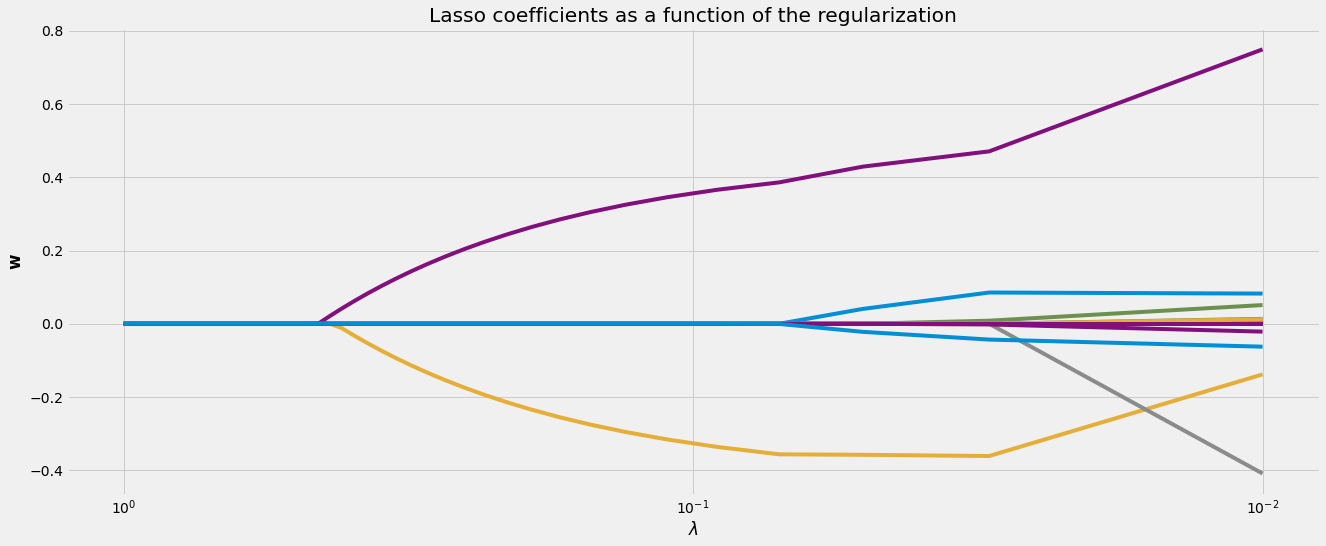

In [35]:
# Lasso
laso = Pipeline([('scaler', StandardScaler()), ('regressor', Lasso(alpha=0.1))])

laso.fit(X_train, y_train)

print(f'R² Train: {laso.score(X_train, y_train):0.4}')
print(f'R² Test: {laso.score(X_test, y_test):0.4}')
print(laso['regressor'].coef_)

lasso_coef_df = pd.DataFrame(laso['regressor'].coef_)

alpha_range = np.linspace(0.01,1,50)

la_coef = []

for i in alpha_range:
    laso = Pipeline([('scaler', StandardScaler()), ('regressor', Lasso(alpha=i))])
    laso.fit(X, Y)
    la_coef.append(laso['regressor'].coef_)
    
mlt.plot_coeff(alpha_range, la_coef, 'Lasso')

Lasso method excluded almost all features, being only with Past returns of 1 day and Momentum of 2 days.

R² Train: 0.4238
R² Test: 0.4877
[ 0.0743785   0.02274716 -0.12480784  0.08798919  0.12798355  0.08648741
 -0.03262072  0.01409515 -0.0285675   0.02454136 -0.60141797  0.77548869
 -0.13889922  0.08281763  0.14843001 -0.02071474 -0.02325511 -0.04455835
  0.12740407  0.0989822   0.10429775 -0.05203407 -0.22629294 -0.00131183
 -0.11898777]


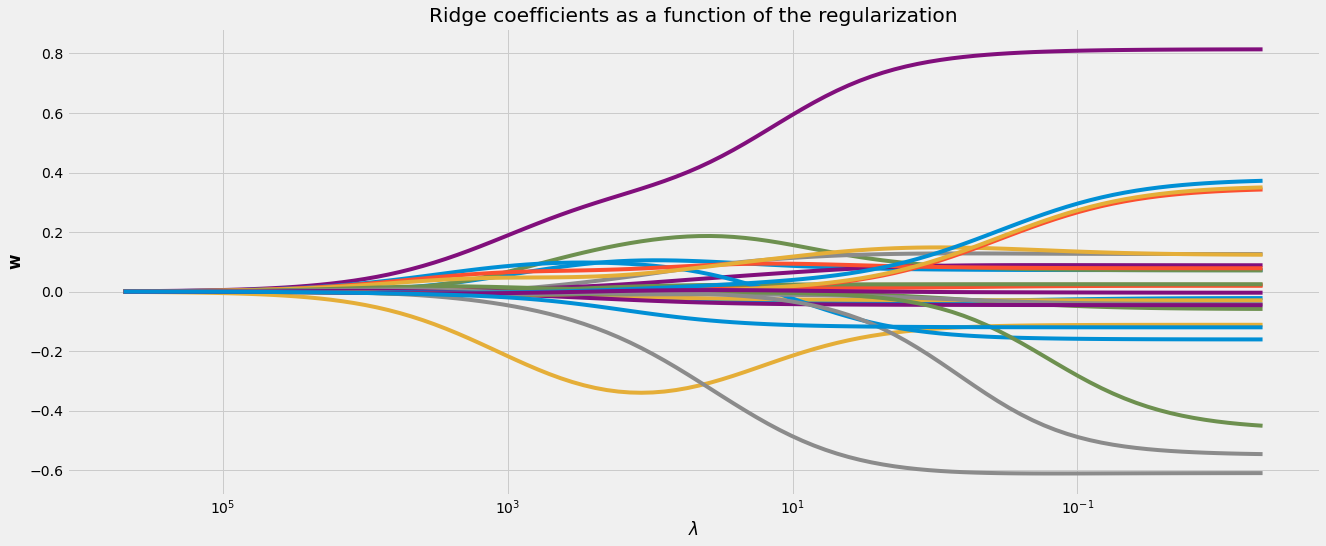

In [36]:
# Ridge
rid = Pipeline([('scaler', StandardScaler()), ('regressor', Ridge(alpha=1))])

rid.fit(X, Y)

print(f'R² Train: {rid.score(X_train, y_train):0.4}')
print(f'R² Test: {rid.score(X_test, y_test):0.4}')
print(rid['regressor'].coef_)

rid_coef_df = pd.DataFrame(rid['regressor'].coef_)

alpha_range = 10**np.linspace(6,-2,100)*0.5
rid_coef = []

for i in alpha_range:
    rid = Pipeline([('scaler', StandardScaler()), ('regressor', Ridge(alpha=i))])
    rid.fit(X, Y)
    rid_coef.append(rid['regressor'].coef_)
    
mlt.plot_coeff(alpha_range, rid_coef, 'Ridge')

Ridge had a better test R² than training (what is good). Probably because of the number of independent variables to predict. Ridge beats Lasso R².

#### (a) produce **a table** comparing L1 and L2 type of penalization: the impact made on regression coefficients; plotting is optional here.

### LASSO

$$L = \frac{1}{n}\sum_{i=1}^{n} {\left(y_i - w_0 - \sum_{j=0}^{p} x_{ij}w_j\right)}^{2} + \lambda \sum_{j=1}^{p}|w_j|$$

### RIDGE

$$L = \frac{1}{n}\sum_{i=1}^{n} {\left(y_i - w_0 - \sum_{j=0}^{p} x_{ij}w_j\right)}^{2} + \lambda \sum_{j=1}^{p}{w_j}^{2}$$

In [37]:
lasso_coef_df.columns = ['L1']
rid_coef_df.columns = ['L2']
comparable_coef_df = lasso_coef_df.join(rid_coef_df)
comparable_coef_df.index=X.columns

comparable_coef_df

,L1,L2
O - C,0.000000,0.074378
H - L,-0.000000,0.022747
Past_returns_1,-0.325638,-0.124808
Past_returns_2,0.000000,0.087989
Past_returns_3,-0.000000,0.127984
Past_returns_4,0.000000,0.086487
Past_returns_5,0.000000,-0.032621
Past_returns_10,0.000000,0.014095
Past_returns_20,0.000000,-0.028567
Past_returns_50,0.000000,0.024541


#### (b) explain in bold font whether L1 or L2 regression likely to have a _high bias_ and _low variance_.

- L1 regularization adds an L1 penalty equal to the absolute value of the magnitude of coefficients. In other words, it limits the size of the coefficients. L1 can yield sparse models (i.e. models with few coefficients); Some coefficients can become zero and eliminated. Lasso regression uses this method.
- L2 regularization adds an L2 penalty equal to the square of the magnitude of coefficients. L2 will not yield sparse models and all coefficients are shrunk by the same factor (none are eliminated). Ridge regression and SVMs use this method.

So, **L2 regression** is likely to generate high bias and low variance models, since it doesn't eliminate any feature. That's enough to produce a complex model, resulting high bias and low variance.

#### (c) plot **logistic sigmoid for three features** winning by largest coefficient and/or significance.

In [38]:
# Features from Ridge Regression: Part_returns_1, Momentum_2, EMA
rid_coef_df.index = X.columns
coeff_matrix = rid_coef_df.T[['Past_returns_1', 'Momentum_2', 'EMA']]
coeff_matrix['Intercept'] = rid['regressor'].intercept_
coeff_matrix.index = ['Coefficients']

coeff_matrix

,Past_returns_1,Momentum_2,EMA,Intercept
Coefficients,-0.124808,0.775489,-0.118988,0.111848


In [39]:
beta_0 = coeff_matrix['Intercept']
beta_1 = coeff_matrix['Past_returns_1']
beta_2 = coeff_matrix['Momentum_2']
beta_3 = coeff_matrix['EMA']

init = -100
final = 100
by = 1

phi_z_Past_returns_1 = mlt.sigmoid(beta_0, beta_1, init, final, by)
phi_z_Momentum_2 = mlt.sigmoid(beta_0, beta_2, init, final, by)
phi_z_EMA = mlt.sigmoid(beta_0, beta_3, init, final, by)
z = np.arange(init, final, by)

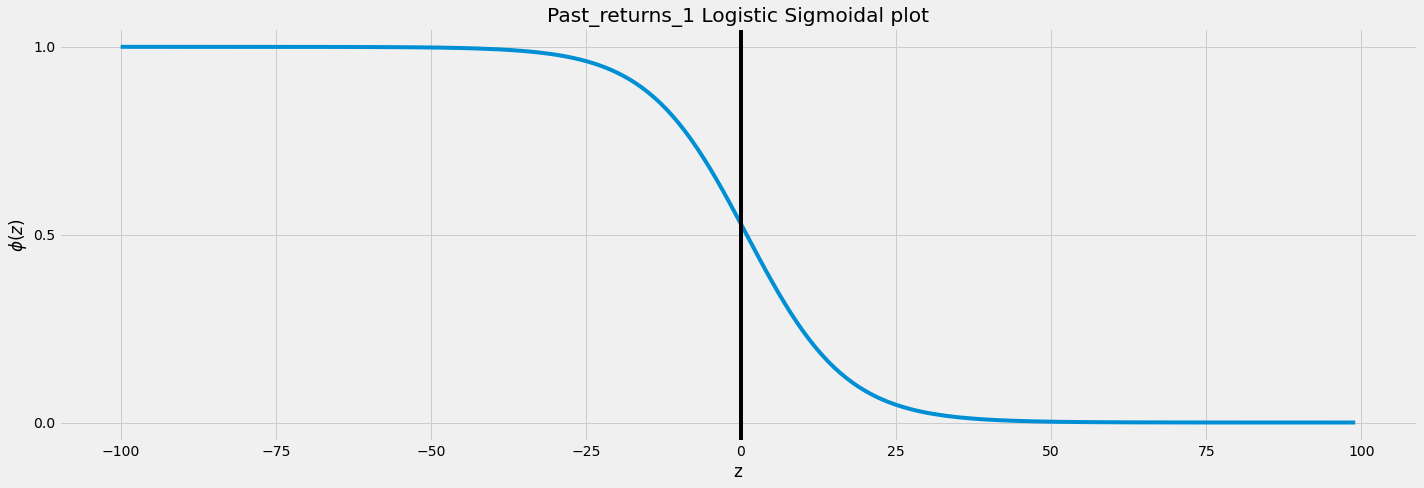

In [40]:
mlt.plot_sigmoidal_features(z, phi_z_Past_returns_1, 'Past_returns_1')

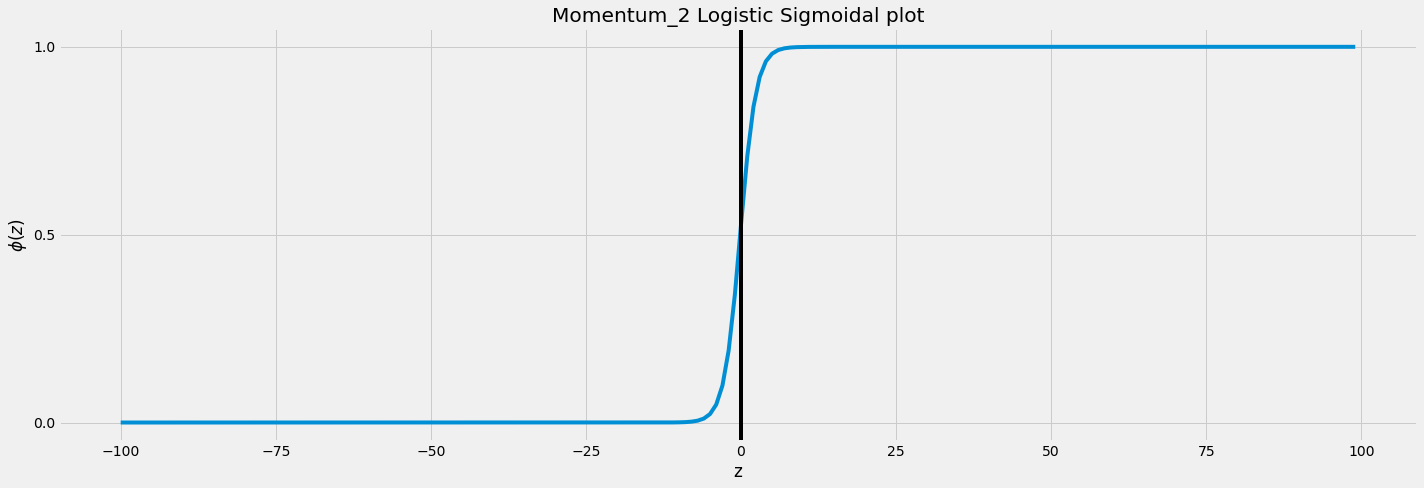

In [41]:
mlt.plot_sigmoidal_features(z, phi_z_Momentum_2, 'Momentum_2')

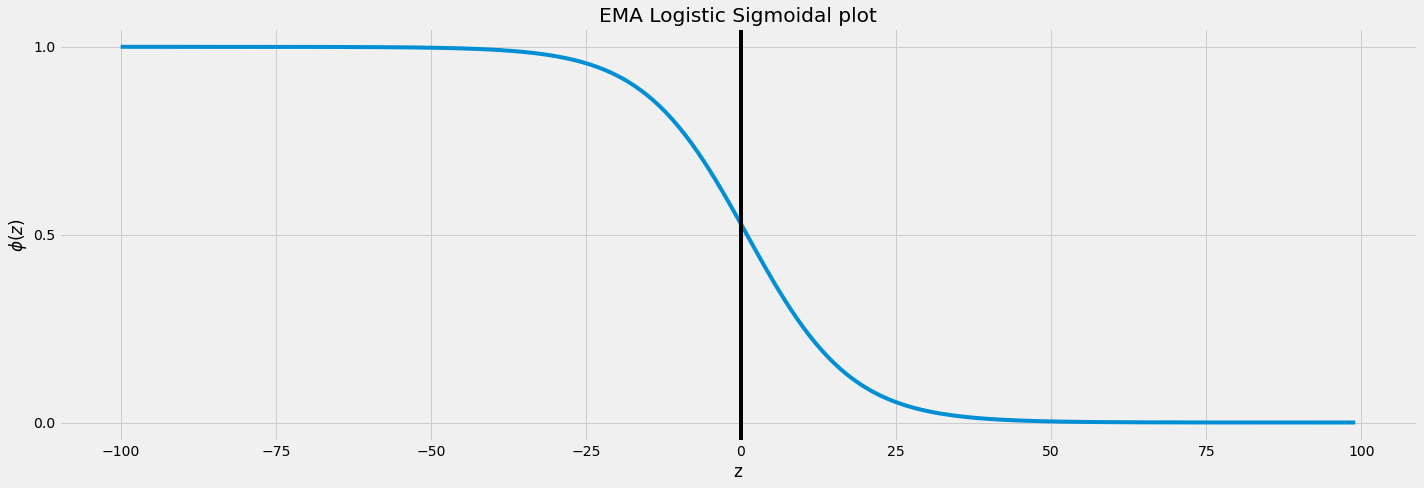

In [42]:
mlt.plot_sigmoidal_features(z, phi_z_EMA, 'EMA')

### 3. Return to a full set of features, implement feature scoring/elimination.

Variance Inflation Factor | SelectKBest | Recursive Elimination | Shapley Values

#### VIF

Multicollinearity occurs when two or more independent variables are highly correlated with one another in a regression model. This means that an independent variable can be predicted from another independent variable in a regression model.

Multicollinearity can be detected using various methods and one such method is Variable Inflation Factors (VIF). VIF determines the strength of the correlation between the independent variables. It is predicted by taking a variable and regressing it against every other variable.

VIF score of an independent variable represents how well the variable is explained by other independent variables.

R² value is determined to find out how well an independent variable is described by the other independent variables. A high value of R² means that the variable is highly correlated with the other variables. This is captured by the VIF which is denoted below:

$$VIF = \frac{1}{1-{R}^{2}}$$

- VIF starts at 1 and has no upper limit.
- VIF = 1, no correlation between the independent variable and the other variables.
- VIF exceeding 5 or 10 indicates high multicollinearity between this independent variable and the others.

In [43]:
vif_df = mlt.vif(X).round(2)

divide by zero encountered in double_scalars


In [44]:
# Drop VIF score > 5
newX = X[['O - C', 'H - L', 'Past_returns_5', 'Past_returns_10', 'Past_returns_20', 'Past_returns_50']]

In [45]:
# Scores in ascending values
new_vif_df = mlt.vif(newX).sort_values(by="VIF Factor")

In [46]:
# Filter the first 3 features
vif_method = X[['H - L', 'O - C', 'Past_returns_50']]

pipe = Pipeline([('scaler', StandardScaler()), ('regressor', LinearRegression())])

# Fit/train model
pipe.fit(vif_method, Y)

# Predict labels
y_pred = pipe.predict(vif_method)

r2_vif = pipe.score(vif_method, Y)

print(f'R²: {pipe.score(vif_method, Y):0.4}')

R²: 0.003421


#### SelectKBest

Select features according to the k highest scores. Univariate feature selection works by selecting the best features based on univariate statistical tests.

In [47]:
skb_method =  SelectKBest(f_regression, k=6) 

# Fit the model
skb_method.fit(X, Y)

SelectKBest(k=6, score_func=<function f_regression at 0x000001D280B74940>)

In [48]:
# Show selected features
skb_method.get_support(indices=True)

array([ 2, 11, 12, 13, 14, 15], dtype=int64)

In [49]:
# Iterate the score
vet = []

for f, s in zip(X.columns, skb_method.scores_):
    vet.append([s,f])
    
vet = pd.DataFrame(vet)
vet.columns = ['Scores', 'Features']

vet

,Scores,Features
0,0.936238,O - C
1,0.923056,H - L
2,271.030957,Past_returns_1
3,2.107397,Past_returns_2
4,0.697963,Past_returns_3
5,0.363812,Past_returns_4
6,0.492960,Past_returns_5
7,0.000014,Past_returns_10
8,1.121646,Past_returns_20
9,0.611250,Past_returns_50


In [50]:
# Filter three features with highest score
skb_method = X[['Past_returns_1', 'Momentum_2', 'Momentum_3']]

In [51]:
# fit/train model
pipe.fit(skb_method, Y)

# predict labels
y_pred = pipe.predict(skb_method)

r2_skb = pipe.score(skb_method, Y)

print(f'R²: {pipe.score(skb_method, Y):0.4}')

R²: 0.3969


#### RFE

Feature ranking with recursive feature elimination (RFE). The goal is to select features by recursively considering smaller and smaller sets of features. 

In [52]:
rfe_method = RFE(LinearRegression(), n_features_to_select=6, step=1)
rfe_method.fit(X,Y)

RFE(estimator=LinearRegression(), n_features_to_select=6)

In [53]:
# Check the selected position
rfe_method.support_

array([False, False, False, False, False, False, False, False, False,
       False, False,  True,  True,  True, False, False, False, False,
        True,  True,  True, False, False, False, False])

In [54]:
# Get the feature ranking
rfe_method.ranking_

array([10, 15,  5,  4,  3, 11,  6,  9,  8,  7,  2,  1,  1,  1, 12, 17, 18,
       19,  1,  1,  1, 13, 14, 20, 16])

In [55]:
# Select Six Features
min_value = min(rfe_method.ranking_)
col = [i for i, x in enumerate(rfe_method.ranking_) if x == min_value]
col

[11, 12, 13, 18, 19, 20]

In [56]:
# Filter selected features
rfe_method = X[['Momentum_2', 'Momentum_3', 'Momentum_4', 'SMA_2', 'SMA_3', 'SMA_5']]

In [57]:
# fit/train model
pipe.fit(rfe_method, Y)

# predict labels
y_pred = pipe.predict(rfe_method)

r2_rfe = pipe.score(rfe_method, Y)

print(f'R²: {pipe.score(rfe_method, Y):0.4}')

R²: 0.4267


#### RFECV

A recursive feature elimination with automatic tuning of the number of features selected with cross-validation.

In [58]:
# Method 4
rfecv_method = RFECV(LinearRegression(), cv=10)
rfecv_method.fit(X,Y)

RFECV(cv=10, estimator=LinearRegression())

In [59]:
# Get the selected features with CV
rfecv_method.n_features_

10

In [60]:
# Get the index of the selected features
rfecv_method.get_support(indices=True)

array([ 2,  3,  4, 10, 11, 12, 13, 18, 19, 20], dtype=int64)

In [61]:
# Check the selected position
rfecv_method.support_

array([False, False,  True,  True,  True, False, False, False, False,
       False,  True,  True,  True,  True, False, False, False, False,
        True,  True,  True, False, False, False, False])

In [62]:
# Get the feature ranking
rfecv_method.ranking_

array([ 6, 11,  1,  1,  1,  7,  2,  5,  4,  3,  1,  1,  1,  1,  8, 13, 14,
       15,  1,  1,  1,  9, 10, 16, 12])

In [63]:
# Select Eight Features
min_value = min(rfecv_method.ranking_)
col = [i for i, x in enumerate(rfecv_method.ranking_) if x == min_value]
col

[2, 3, 4, 10, 11, 12, 13, 18, 19, 20]

In [64]:
# Iterate to get features
for i in range(len(col)):
    print(X.columns[col[i]])

Past_returns_1
Past_returns_2
Past_returns_3
Momentum_1
Momentum_2
Momentum_3
Momentum_4
SMA_2
SMA_3
SMA_5


In [65]:
# Filter selected features
rfecv_method = X[['Past_returns_1', 'Past_returns_2', 'Past_returns_3', 'Past_returns_5', 'Momentum_1', 'Momentum_2', 'Momentum_3', 'Momentum_4', 'SMA_2', 'SMA_3', 'SMA_5']]

In [66]:
# fit/train model
pipe.fit(rfecv_method, Y)

# predict labels
y_pred = pipe.predict(rfecv_method)

r2_rfecv = pipe.score(rfecv_method, Y)

print(f'R²: {pipe.score(rfecv_method, Y):0.4}')

R²: 0.4301


#### SHAP

SHAP (SHapley Additive exPlanations) is a game theoretic approach to explain the output of any machine learning model. It connects optimal credit allocation with local explanations using the classic Shapley values from game theory and their related extensions.

Shapley values are a widely used approach from cooperative game theory that come with desirable properties and is the average marginal contribution of a feature value across all possible coalitions.

In [67]:
# Shapley values
# 100 instances for use as the background distribution
X100 = shap.utils.sample(X, 100, random_state=42)
pipe.fit(X, Y)

Pipeline(steps=[('scaler', StandardScaler()),
                ('regressor', LinearRegression())])

In [68]:
# compute the SHAP values for the linear model
explainer = shap.Explainer(pipe.predict, X100)
shap_values = explainer(X)

Permutation explainer: 1208it [00:24, 31.23it/s]                          


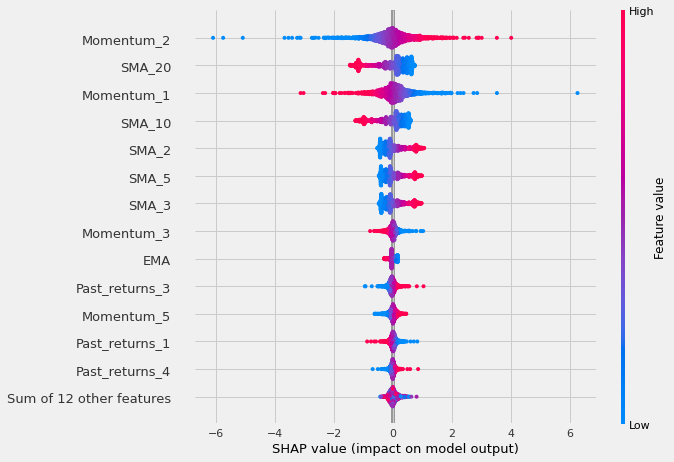

In [69]:
shap.plots.beeswarm(shap_values, max_display=14)

The above plot shows the feature importance of a linear model where the variables are ranked in descending order and the horizontal location shows whether the effect of that value is associated with a higher or lower prediction.

- Color shows whether that variable is high (in red) or low (in blue) for that observation.
- A high level has a high and positive impact on the quality rating.
- Impact is shown on the X-axis.

In [70]:
# Filter selected features
shap_method = X[['Momentum_1', 'Momentum_2', 'Momentum_3', 'SMA_2', 'SMA_3', 'SMA_5', 'SMA_10', 'SMA_20', 'Past_returns_3']]

In [71]:
# fit/train model
pipe.fit(shap_method, Y)

# predict labels
y_pred = pipe.predict(shap_method)

r2_shap = pipe.score(shap_method, Y)

print(f'R²: {pipe.score(shap_method, Y):0.4}')

R²: 0.4294


#### Original features

In [72]:
pipe = Pipeline([('scaler', StandardScaler()), ('regressor', LinearRegression())])

# fit/train model
pipe.fit(X, Y)

r2_orig = pipe.score(X, Y)

print(f'R^2: {pipe.score(X, Y):0.4}')

R^2: 0.4368


#### Comparison

In [73]:
r2_df = pd.DataFrame({'Original Features Set': [r2_orig], 'VIF': [r2_vif], 'SelectKBest': [r2_skb], 
                      'RFE': [r2_rfe], 'RFECV': [r2_rfecv], 'Shapley Values': [r2_shap]})
r2_df.index = ['R²']
r2_df = r2_df.T

r2_df

,R²
Original Features Set,0.436775
VIF,0.003421
SelectKBest,0.396895
RFE,0.426672
RFECV,0.430076
Shapley Values,0.429423


#### (a) choose at least two approaches and briefy indicate the main property and key maths for each. For example, VIF focuses on interdependent (colinear) features.

#### RFECV

Recursive feature elimination (RFE) is a feature selection method that fits a model and removes the weakest feature (or features) until the specified number of features is reached.

#### Shapley Values

The Shapley value provides a principled way to explain the predictions of nonlinear models common in the field of machine learning. By interpreting a model trained on a set of features as a value function on a coalition of players, Shapley values provide a natural way to compute which features contribute to a prediction. The formal way to illustrate the method is shown below:

$$\varphi_i (\upsilon ) = \frac{1}{n!} \sum_{R} \left[\upsilon({P_i}^{R}\cup \left\{ i \right\}) - \upsilon({P_i}^{R})\right]$$

#### (b) plot **the logistic sigmoid** for 3-4 winning features.

In [74]:
# Features from Ridge Regression: Momentum_1, Momentum_2, EMA
linear_coef_df = pd.DataFrame(pipe['regressor'].coef_)
linear_coef_df.index = X.columns
coeff_matrix = linear_coef_df.T[['Past_returns_1', 'Momentum_2', 'Momentum_3']]
coeff_matrix['Intercept'] = pipe['regressor'].intercept_
coeff_matrix.index = ['Coefficients']

coeff_matrix

,Past_returns_1,Momentum_2,Momentum_3,Intercept
Coefficients,-0.111529,0.814119,-0.160817,0.111848


In [75]:
# Winning features: 'Past_returns_1', 'Momentum_2', 'Momentum_3'
beta_0 = coeff_matrix['Intercept']
beta_1 = coeff_matrix['Past_returns_1']
beta_2 = coeff_matrix['Momentum_2']
beta_3 = coeff_matrix['Momentum_3']

init = -100
final = 100
by = 1

phi_z_Momentum_1 = mlt.sigmoid(beta_0, beta_1, init, final, by)
phi_z_Momentum_2 = mlt.sigmoid(beta_0, beta_2, init, final, by)
phi_z_EMA = mlt.sigmoid(beta_0, beta_3, init, final, by)
z = np.arange(init, final, by)

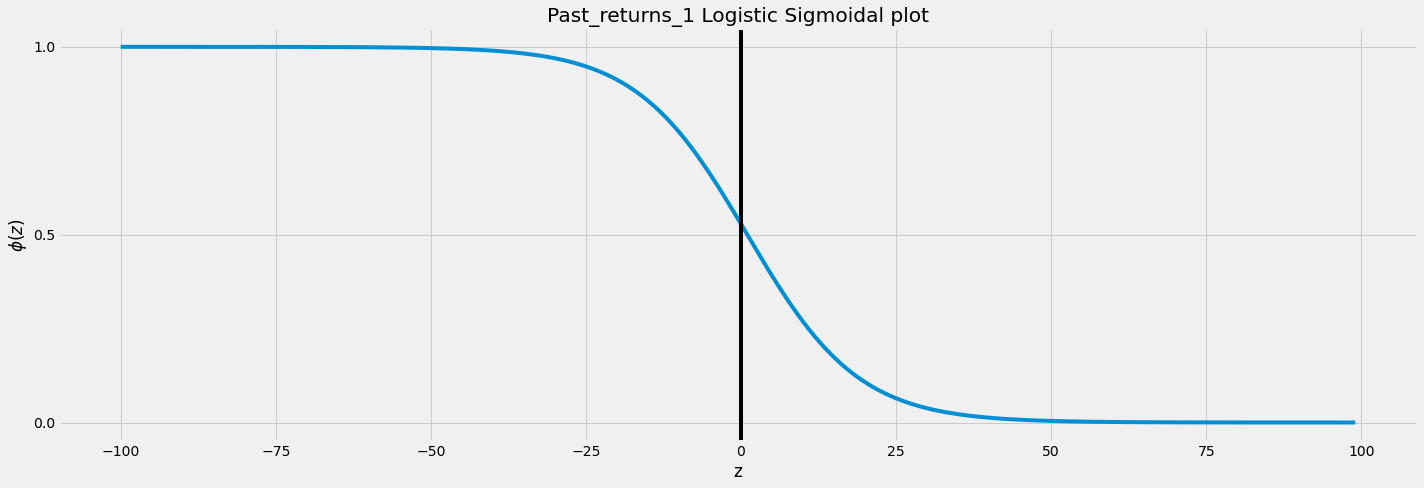

In [76]:
mlt.plot_sigmoidal_features(z, phi_z_Momentum_1, 'Past_returns_1')

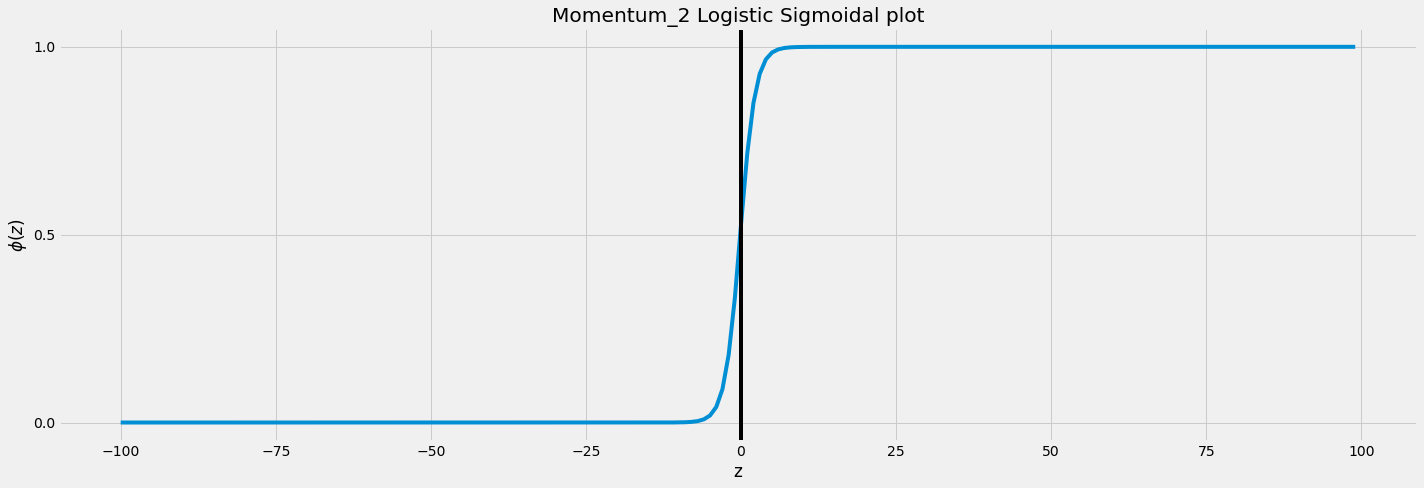

In [77]:
mlt.plot_sigmoidal_features(z, phi_z_Momentum_2, 'Momentum_2')

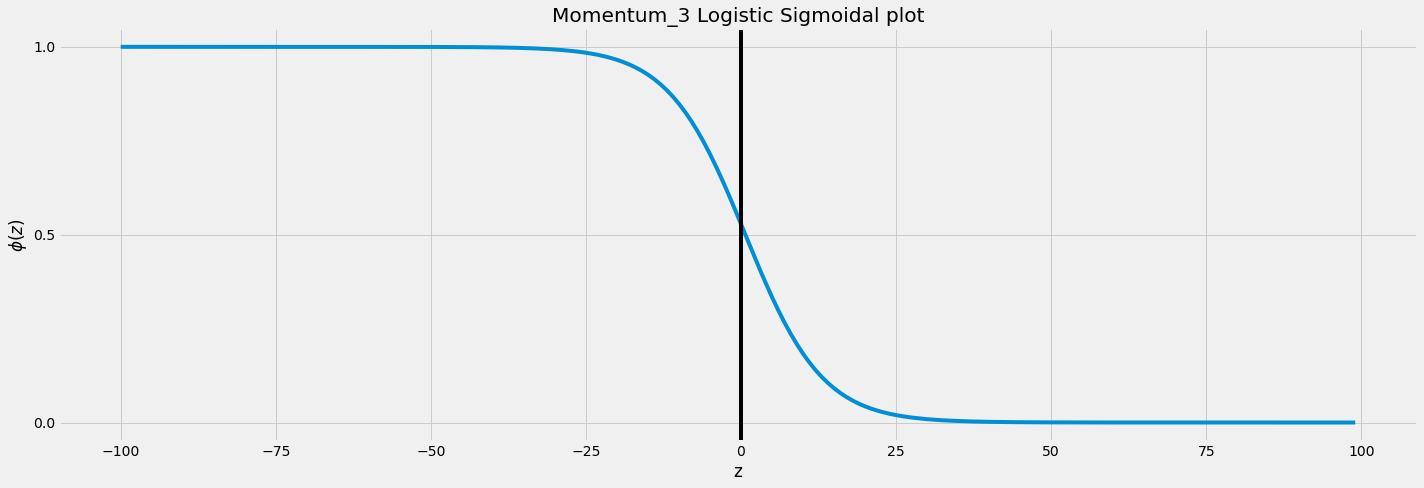

In [78]:
mlt.plot_sigmoidal_features(z, phi_z_EMA, 'Momentum_3')

### 4. For the best model of your choice - restricted in features by Q2 penalization or Q3 feature elimination (or combination of both approaches) produce evaluation: area under ROC curve plots for each class 0, 1 and confusion matrix. Give expressions for precision/recall.

A receiver operating characteristic curve, or ROC curve, is a graphical plot that illustrates the diagnostic ability of a binary classifier system as its discrimination threshold is varied.
The ROC curve is created by plotting the true positive rate (TPR) against the false positive rate (FPR) at various threshold settings. The true-positive rate is also known as sensitivity, recall or probability of detection in machine learning. The false-positive rate is also known as probability of false alarm and can be calculated as (1 − specificity).

Using the K Nearest Neighbors model for selected features: Past_returns_1, Momentum_2 and EMA.

In [79]:
pipe = Pipeline([("scaler", StandardScaler()), ("classifier", KNeighborsClassifier())])

X = X[['Past_returns_1', 'Momentum_2', 'EMA']]

X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=0)

pipe.fit(X_train, y_train)

Pipeline(steps=[('scaler', StandardScaler()),
                ('classifier', KNeighborsClassifier())])

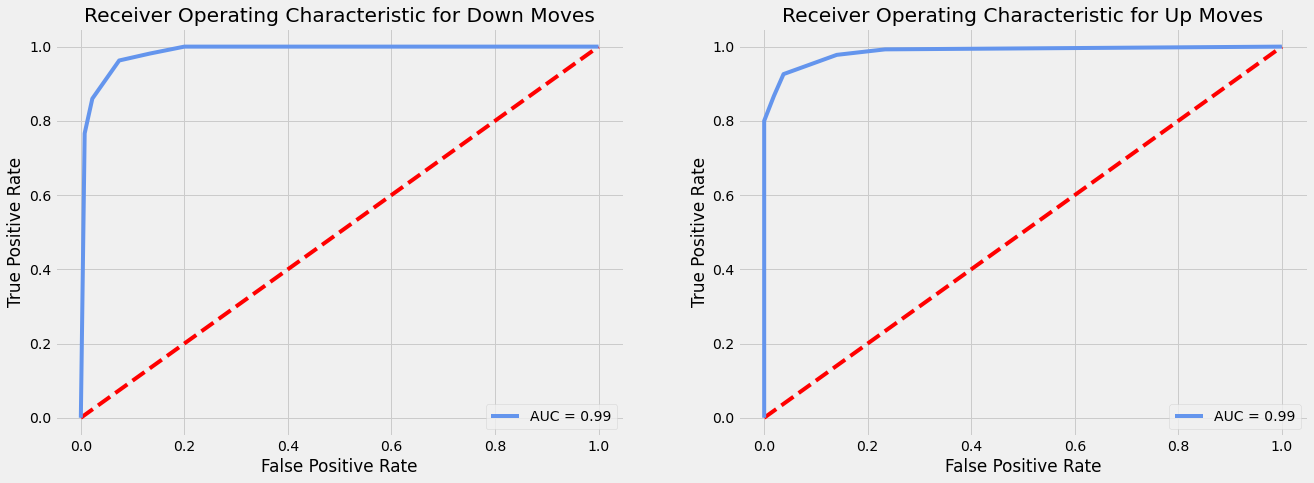

In [80]:
probs = pipe.predict_proba(X_test)
preds1 = probs[:, 0]
preds2 = probs[:, 1]

fpr1, tpr1, threshold1 = roc_curve(y_test, preds1, pos_label=-1)
roc_auc1 = auc(fpr1, tpr1)

fpr2, tpr2, threshold2 = roc_curve(y_test, preds2, pos_label=1)
roc_auc2 = auc(fpr2, tpr2)

fig, ax = plt.subplots(nrows=1, ncols=2)

ax[0].plot([0, 1], [0, 1], 'r--')
ax[0].plot(fpr1, tpr1, 'cornflowerblue', label=f'AUC = {roc_auc1:0.2}')
ax[0].set_title("Receiver Operating Characteristic for Down Moves")
ax[0].set_xlabel('False Positive Rate')
ax[0].set_ylabel('True Positive Rate')

ax[1].plot([0, 1], [0, 1], 'r--')
ax[1].plot(fpr2, tpr2, 'cornflowerblue', label=f'AUC = {roc_auc2:0.2}')
ax[1].set_title("Receiver Operating Characteristic for Up Moves")
ax[1].set_xlabel('False Positive Rate')
ax[1].set_ylabel('True Positive Rate')

# Define legend
ax[0].legend(), ax[1].legend();

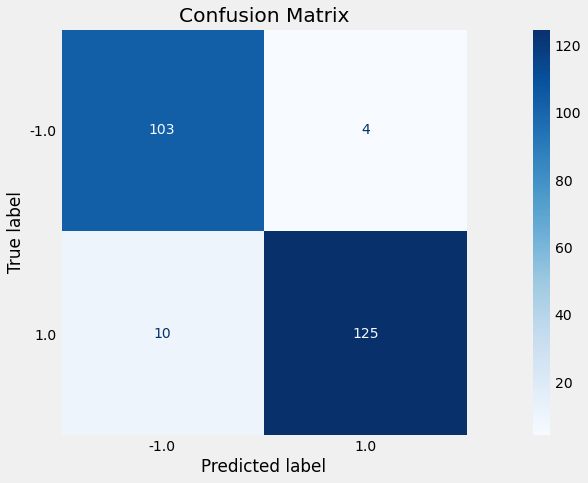

In [81]:
# Plot confusion matrix
plot_confusion_matrix(pipe, X_test, y_test, cmap='Blues', values_format='.4g')
plt.title('Confusion Matrix')
plt.grid(False)

In [82]:
y_pred = pipe.predict(X_test)
TN, FP, FN, TP = confusion_matrix(y_test, y_pred).ravel()
print(f'The confusion matrix is saying that our model predicted {TP} times up moves and was right, \n{FP} times up moves and was wrong, {FN} times down moves and was wrong and {TN} down moves and was right.')

The confusion matrix is saying that our model predicted 125 times up moves and was right, 
4 times up moves and was wrong, 10 times down moves and was wrong and 103 down moves and was right.


##### Sensitivity, recall, hit rate, or true positive rate (TPR)

$$TPR = \frac{TP}{P} = \frac{TP}{TP + FN} = 1 - \frac{FP}{P}$$

In [83]:
TPR = TP/(TP + FN)
print(f'The true positive rate has value of {TPR:.4f}')

The true positive rate has value of 0.9259


##### Precision or positive predictive value (PPV)

$$PPV = \frac{TP}{TP + FP} = 1 - \frac{FP}{FP + TP}$$

In [84]:
PPV = TP/(TP + FP)
print(f'The Precision has value of {PPV:.4f}')

The Precision has value of 0.9690


where $TP$ is True Positive, $TN$ is True Negative, $FP$ is False Positive and $FN$ is False Negative.

### 5. Call _predict_proba()_ method. Provide scatter plots of transition probabilities of up moves, and another separate plot for down moves. It is required to use color-coding to indicate correctly/incorrectly predicted values on each scatter plot.

In [85]:
pipe = Pipeline([("scaler", StandardScaler()), ("classifier", KNeighborsClassifier())])

X = X[['Past_returns_1', 'Momentum_2', 'EMA']]

X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=0)

pipe.fit(X_train, y_train)

probs = pipe.predict_proba(X_test)

In [86]:
all_data_df = pd.DataFrame(probs)
all_data_df.columns = ['Prob. to -1','Prob. to 1']

y_pred = pipe.predict(X_test)
y_pred = pd.DataFrame(y_pred)
y_pred.columns = ['Y Pred']

y_test = pd.DataFrame(y_test)
y_test.columns = ['Y Test']

index_df = np.arange(0, len(y_pred), 1)

all_data_df['Index'] = index_df

y_pred['Index'] = index_df

y_test['Index'] = index_df

all_data_df = all_data_df.merge(y_pred, on='Index', how='inner')
all_data_df = all_data_df.merge(y_test, on='Index', how='inner')
all_data_df = all_data_df.drop(['Index'], 1)

In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only


In [87]:
vet = []

for idx in range(0, len(all_data_df.index), 1):
    if all_data_df['Prob. to -1'][idx] > 0.5:
        if all_data_df['Y Test'][idx] == -1:
            vet.append('Correct down move')
        else:
            vet.append('Incorrect down move')
            
    if all_data_df['Prob. to 1'][idx] > 0.5:
        if all_data_df['Y Test'][idx] == 1:
            vet.append('Correct up move')
        else:
            vet.append('Incorrect up move')
            
all_data_df['Corr/Incorr'] = vet

In [88]:
vet_up = []
vet_down = []

for idx in range(0, len(all_data_df.index), 1):
    if all_data_df['Y Pred'][idx] > 0:
        vet_up.append([all_data_df['Prob. to -1'][idx], all_data_df['Prob. to 1'][idx], 
                       all_data_df['Y Pred'][idx], all_data_df['Y Test'][idx], 
                       all_data_df['Corr/Incorr'][idx]])
    if all_data_df['Y Pred'][idx] < 0:
        vet_down.append([all_data_df['Prob. to -1'][idx], all_data_df['Prob. to 1'][idx], 
                         all_data_df['Y Pred'][idx], all_data_df['Y Test'][idx], 
                         all_data_df['Corr/Incorr'][idx]])

##### Up moves

In [89]:
vet_up = pd.DataFrame(vet_up)
vet_up.columns = all_data_df.columns
vet_up.tail()

,Prob. to -1,Prob. to 1,Y Pred,Y Test,Corr/Incorr
124,0.4,0.6,1.0,1.0,Correct up move
125,0.0,1.0,1.0,1.0,Correct up move
126,0.2,0.8,1.0,1.0,Correct up move
127,0.0,1.0,1.0,1.0,Correct up move
128,0.0,1.0,1.0,1.0,Correct up move


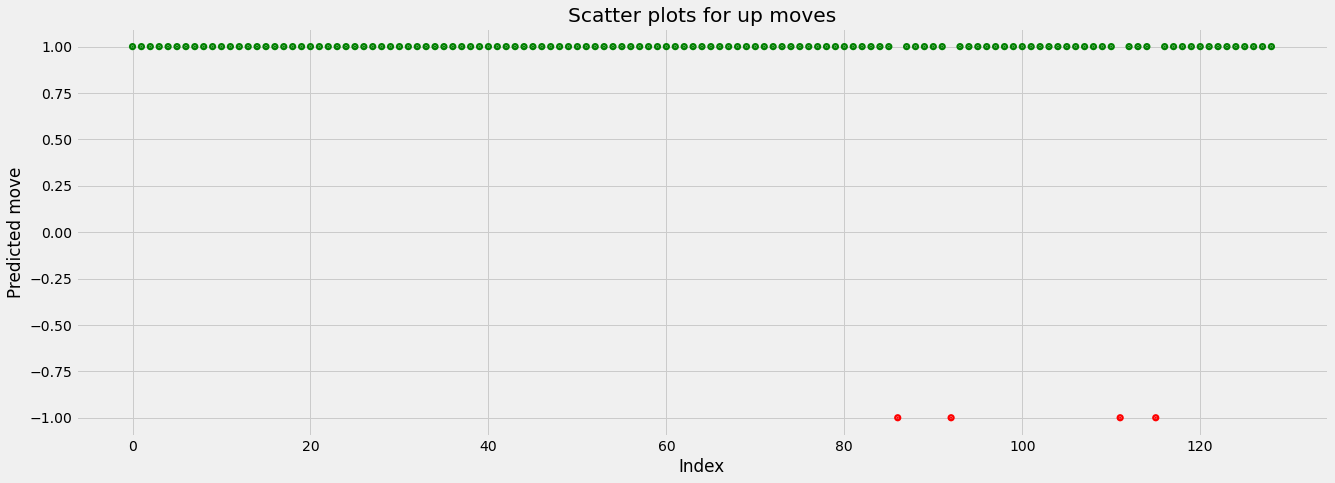

In [90]:
plot_x = np.arange(0, len(vet_up.index), 1)
plot_y_pred = vet_up['Y Pred']
plot_y_test = vet_up['Y Test']

col = np.where(plot_y_pred == plot_y_test, 'g', 'r')

plt.scatter(plot_x, plot_y_test, c=col, s=5, linewidth=5)
plt.title("Scatter plots for up moves")
plt.xlabel('Index')
plt.ylabel('Predicted move')
plt.show()

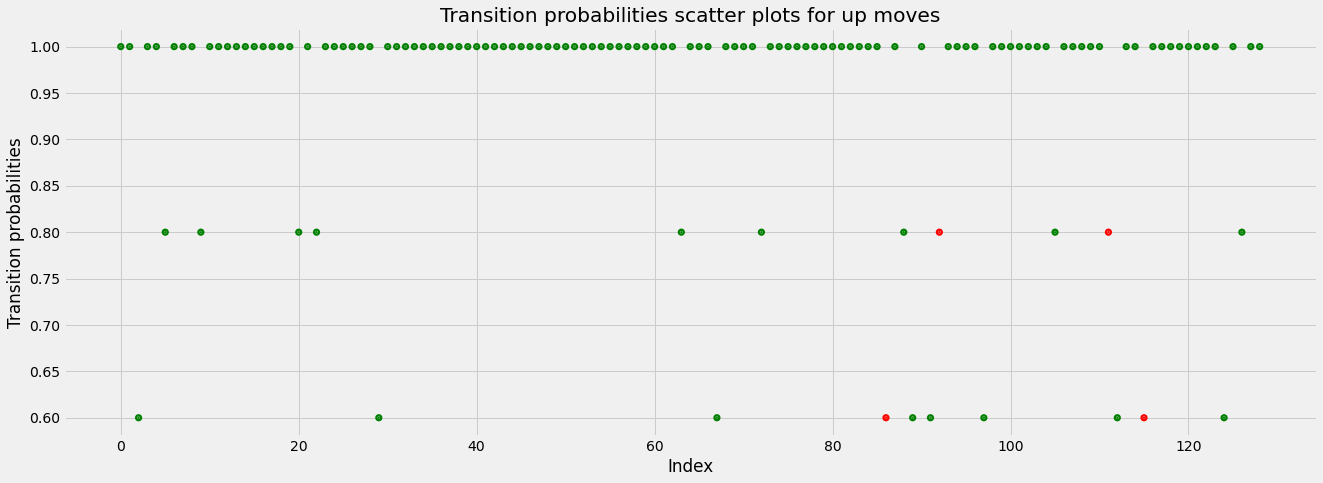

In [91]:
plot_x = np.arange(0, len(vet_up.index), 1)
plot_y_trans = vet_up['Prob. to 1']
y_test = vet_up['Y Test']

col = np.where((y_test == 1), 'g', 'r')

plt.scatter(plot_x, plot_y_trans, c=col, s=5, linewidth=5)
plt.title("Transition probabilities scatter plots for up moves")
plt.xlabel('Index')
plt.ylabel('Transition probabilities')
plt.show()

##### Down moves

In [92]:
vet_down = pd.DataFrame(vet_down)
vet_down.columns = all_data_df.columns
vet_down.tail()

,Prob. to -1,Prob. to 1,Y Pred,Y Test,Corr/Incorr
108,1.0,0.0,-1.0,-1.0,Correct down move
109,1.0,0.0,-1.0,1.0,Incorrect down move
110,0.6,0.4,-1.0,-1.0,Correct down move
111,1.0,0.0,-1.0,-1.0,Correct down move
112,0.6,0.4,-1.0,-1.0,Correct down move


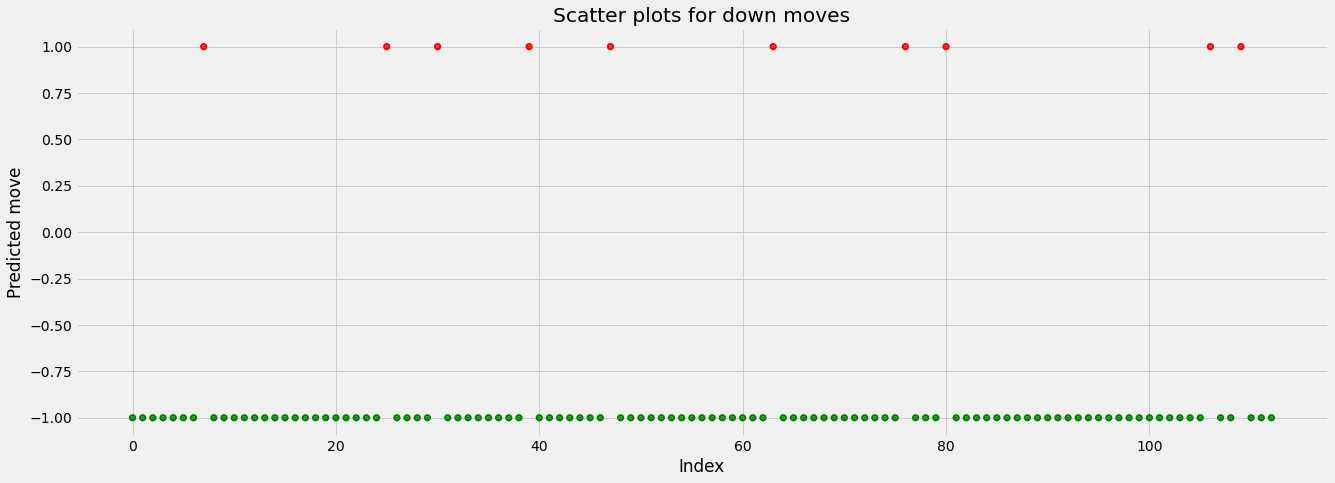

In [93]:
plot_x = np.arange(0, len(vet_down.index), 1)
plot_y_pred = vet_down['Y Pred']
plot_y_test = vet_down['Y Test']

col = np.where(plot_y_pred == plot_y_test, 'g', 'r')

plt.scatter(plot_x, plot_y_test, c=col, s=5, linewidth=5)
plt.title("Scatter plots for down moves")
plt.xlabel('Index')
plt.ylabel('Predicted move')
plt.show()

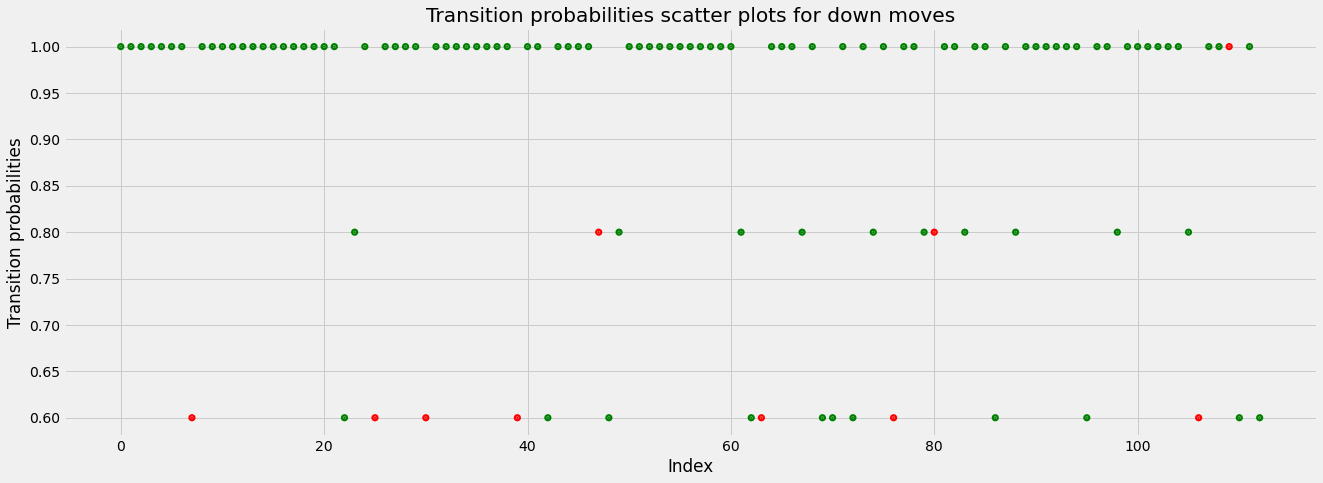

In [94]:
plot_x = np.arange(0, len(vet_down.index), 1)
plot_y_trans = vet_down['Prob. to -1']
y_test = vet_down['Y Test']

col = np.where((y_test == -1), 'g', 'r')

plt.scatter(plot_x, plot_y_trans, c=col, s=5, linewidth=5)
plt.title("Transition probabilities scatter plots for down moves")
plt.xlabel('Index')
plt.ylabel('Transition probabilities')
plt.show()